# Sanity check: There are large biases in the previous recovery tests, possibly due to the SNR put in, trying with a smaller SNR
`metallicity model recovery tests.ipynb` and `metallicity model recovery tests2.ipynb` did a lot of tests looking into how well the models recovery parameters from mock spectra, if there are biases in the more complex models, etc. Some more things require addressing:
1. There seems to be systematic biases in some of the extimated parameters, namely Mstar, Zold, etc, no matter the fitting setup. These should not exist. Could they be features of the biases inhetit in the combinations of priors and models, that are expressed when the input obs noise is just a flat SNR array? Trying to shrink the noise by increase SNR...

In [7]:
import bagpipes as pipes
# setting bagpipes R_spec to as high as possible for perfect generation of models
pipes.config.R_spec = 4340
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70., Om0=0.3)

import sys
sys.path.append('../../..')
from code_bits.fitting import *
from code_bits.add_psbtwin import *
from code_bits.add_ceh_funcs import *

In [2]:
# load in true SFH
model_ages_original, model_sfh = load_model_sfh('../../../Yirui_test_cube/snap119/2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_snap119_SFH_at_diff_radius.txt')

3623.3599 7799.9995


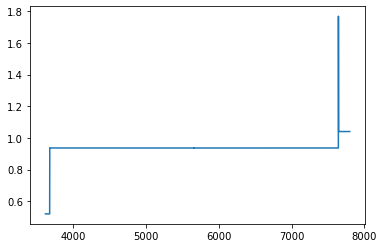

In [3]:
spectrum = np.loadtxt(fname='../../../Yirui_test_cube/snap119/with_PSF/no_dust/Spectrum_'+
                      "2xSc_07_EC_BH_vw1e4_ReposNoRFBNoRP_with_PSF_no_dust_SNR15_outshining_test"+".csv", 
                      delimiter=',', skiprows=1)
obs_wavs = spectrum[:,0][np.where((spectrum[:,0]>3623) & (spectrum[:,0]<7500*(1+0.04)))]
print(min(obs_wavs), max(obs_wavs))
plt.plot(obs_wavs[:-1], np.diff(obs_wavs))

### To avoid the severe bias to the `age` parameter in psb SFH comps (means the lookback time of beginning of star formation), I am shifting and compressing Yirui's model truth SFH closer to the observation time, making beginning of star formation to be closer to cosmic noon at z~2-3.

10.350524938318015 Gyr


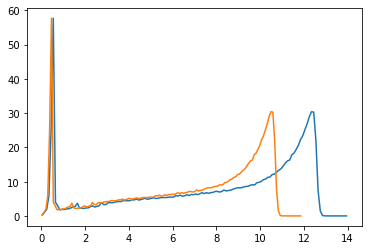

In [4]:
squishing_factor = 0.85
model_ages = model_ages_original*squishing_factor
plt.plot(model_ages_original, model_sfh)
plt.plot(model_ages, model_sfh)
print(cosmo.age(0.04) - cosmo.age(2.5))

[1.06817341e+01 3.23549458e+00 4.67499997e-01 2.29522818e+02
 5.34899465e+02 9.24162911e-02 1.09328153e+01]
[1.06870221e+01 1.63461055e+00 9.95242899e+04 4.67499980e-01
 2.26365783e+02 5.90580893e+02 8.71638738e-02 1.09474482e+01]


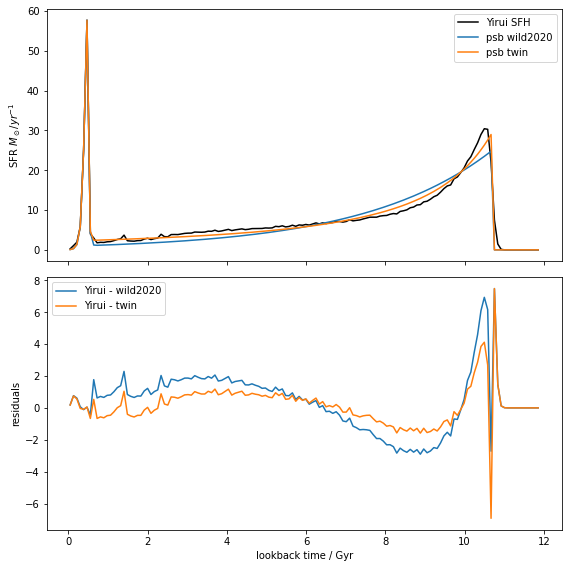

In [5]:
import scipy
# using scipy curve fit to get a fit to the true SFH
popt_wild2020,pcov = scipy.optimize.curve_fit(psb_wild2020, model_ages, model_sfh, 
                                     bounds=([10.5,0.5,0,100,100,0,10],[13,10,2,1000,1000,1,12]))
# best fits
print(popt_wild2020)

# using scipy curve fit to get a fit to the true SFH
popt_twin,pcov = scipy.optimize.curve_fit(psb_twin_, model_ages, model_sfh, 
                                     bounds=([10,0.01,1000,0,10,1,0,10],[13,1000,100000,2,1000,1000,1,12]))
# best fits
print(popt_twin)

fig,ax = plt.subplots(2,1, figsize=[8,8], sharex=True)

predict_sfh_wild2020 = psb_wild2020(model_ages, *popt_wild2020)
predict_sfh_twin = psb_twin_(model_ages, *popt_twin)
ax[0].plot(model_ages, model_sfh, label='Yirui SFH', color='k')
ax[0].plot(model_ages, predict_sfh_wild2020, label='psb wild2020')
ax[0].plot(model_ages, predict_sfh_twin, label='psb twin')
ax[0].set_ylabel('SFR $M_\odot / yr^{-1}$')
ax[0].legend()

ax[1].plot(model_ages, model_sfh-predict_sfh_wild2020, label='Yirui - wild2020')
ax[1].plot(model_ages, model_sfh-predict_sfh_twin, label='Yirui - twin')
ax[1].set_ylabel('residuals')
ax[1].set_xlabel('lookback time / Gyr')
ax[1].legend()
plt.tight_layout()
plt.show()

In [6]:
"""
cols = [m_SFH, m_CEH, m_zmet_old, m_zmet_burst, 
        m_zmet_slope, f_SFH, f_CEH, f_CEH_fixed, 
        f_nlive]
"""
fits_list = []
# delta
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':1.0, 'm_veldisp':100, 'f_SNR':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_zmet_prior':'uniform', 'f_nlive':400,
                 'm_dust':None, 'f_dust':None, 'f_GPnoise':False,
                 'binby':1})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':2.0, 'm_veldisp':100, 'f_SNR':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'delta', 'f_CEH_fixed':False,
                 'f_zmet_prior':'uniform', 'f_nlive':400,
                 'm_dust':None, 'f_dust':None, 'f_GPnoise':False,
                 'binby':1})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'delta',
                 'm_zmet_old':2.0, 'm_veldisp':100, 'f_SNR':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_zmet_prior':'uniform', 'f_nlive':400,
                 'm_dust':None, 'f_dust':None, 'f_GPnoise':False,
                 'binby':1})
fits_list.append({'m_SFH':'psb_wild2020', 'm_CEH':'2step',
                 'm_zmet_old':1.0, 'm_zmet_burst':2.0, 'm_veldisp':100, 'f_SNR':100,
                 'f_SFH':'psb_wild2020',
                 'f_CEH':'2step', 'f_CEH_fixed':False,
                 'f_zmet_prior':'uniform', 'f_nlive':400,
                 'm_dust':None, 'f_dust':None, 'f_GPnoise':False,
                 'binby':1})


fit_table = pd.DataFrame(fits_list)

std_labels = ['m_SFH', 'm_CEH', 'm_zmet_old', 'm_zmet_burst', 'm_zmet_slope', 'm_dust', 'm_veldisp', 
              'f_SFH', 'f_CEH', 'f_CEH_fixed', 'f_zmet_prior', 'f_dust', 'f_GPnoise', 'f_SNR',
              'f_nlive', 'binby']
picked_labels = []
for label in std_labels:
    if label in fit_table.columns:
        picked_labels.append(label)
fit_table = fit_table[picked_labels]

fit_table['m_dust'] = fit_table['m_dust'].where(fit_table['m_dust'].notnull(), None)
fit_table['f_dust'] = fit_table['f_dust'].where(fit_table['f_dust'].notnull(), None)
fit_table['f_GPnoise'] = fit_table['f_GPnoise'].where(fit_table['f_GPnoise'].notnull(), False)
fit_table['binby'] = fit_table['binby'].where(fit_table['binby'].notnull(), 1)

fit_table

,m_SFH,m_CEH,m_zmet_old,m_zmet_burst,m_dust,m_veldisp,f_SFH,f_CEH,f_CEH_fixed,f_zmet_prior,f_dust,f_GPnoise,f_SNR,f_nlive,binby
0,psb_wild2020,delta,1.0,NaN,None,100,psb_wild2020,delta,False,uniform,None,False,100,400,1
1,psb_wild2020,delta,2.0,NaN,None,100,psb_wild2020,delta,False,uniform,None,False,100,400,1
2,psb_wild2020,delta,2.0,NaN,None,100,psb_wild2020,2step,False,uniform,None,False,100,400,1
3,psb_wild2020,2step,1.0,2.0,None,100,psb_wild2020,2step,False,uniform,None,False,100,400,1


In [8]:
def genIDs(fit_settings):
    # galID = {m_SFH}_{m_CEH}{delta's metallicity}
    if fit_settings['m_SFH'] == 'yirui':
        m_SFH = fit_settings['m_SFH']
    elif fit_settings['m_SFH'] == 'psb_wild2020':
        m_SFH = 'psb2'
    elif fit_settings['m_SFH'] == 'psb_twin':
        m_SFH = 'psbtwin'
        
    if fit_settings['m_CEH'] == 'delta':
        m_CEH = 'uniform'+str(int(fit_settings['m_zmet_old']))+'Zsun'
    elif fit_settings['m_CEH'] == '2step':
        m_CEH = f'2step{int(fit_settings["m_zmet_old"])}to{int(fit_settings["m_zmet_burst"])}Zsun'
    else: m_CEH = fit_settings['m_CEH']
        
    if fit_settings['m_dust'] is not None:
        m_dust = '_'+fit_settings['m_dust']
    else: m_dust = ''
        
    veldisp = fit_settings['m_veldisp']
    
    galID = f'{m_SFH}_{m_CEH}{m_dust}_veldisp{veldisp}'
    
    # runID = {f_SFH}_{f_CEH}_{fixed or not}_{nlive}
    if fit_settings['f_SFH'] == 'psb_wild2020':
        f_SFH = 'psb2'
    elif fit_settings['f_SFH'] == 'psb_twin':
        f_SFH = 'psbtwin'
    
    f_CEH = fit_settings['f_CEH']
    
    if fit_settings['f_CEH_fixed']:
        f_CEH_fixed = '_fixed'
    else: f_CEH_fixed = ''
    
    f_zmet_prior = '_'+fit_settings['f_zmet_prior']
    
    if fit_settings['f_dust'] is not None:
        f_dust = '_'+fit_settings['f_dust']
    else: f_dust = ''
        
    if fit_settings['f_GPnoise']:
        f_GPnoise = '_GPon'
    else: f_GPnoise = ''
    
    runID = f"{f_SFH}_{f_CEH}{f_zmet_prior}{f_CEH_fixed}{f_dust}{f_GPnoise}"+\
        f"_SNR{fit_settings['f_SNR']}_nlive{str(fit_settings['f_nlive'])}"+ \
        f"_bin_by_{int(fit_settings['binby'])}_4340_Rspec_veldispOn"
    
    return galID, runID

fit_table['galID'] = ''
fit_table['runID'] = ''
for i,row in fit_table.iterrows():
    galID, runID = genIDs(row)
    print(galID, runID)
    fit_table.loc[i,'galID'] = galID
    fit_table.loc[i,'runID'] = runID
# old_fit = True means that it is recycling a previously-done fit for another test that also fit the
# requirements, but used the non-altered version of Yirui's true SFH. This means the results will not be
# directly comparable but conclusions should still be possible to be drawn
fit_table['old_fit'] = [False]*len(fit_table.index)
                        
fit_table

psb2_uniform1Zsun_veldisp100 psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_uniform2Zsun_veldisp100 psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_uniform2Zsun_veldisp100 psb2_2step_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn
psb2_2step1to2Zsun_veldisp100 psb2_2step_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn


,m_SFH,m_CEH,m_zmet_old,m_zmet_burst,m_dust,m_veldisp,f_SFH,f_CEH,f_CEH_fixed,f_zmet_prior,f_dust,f_GPnoise,f_SNR,f_nlive,binby,galID,runID,old_fit
0,psb_wild2020,delta,1.0,NaN,None,100,psb_wild2020,delta,False,uniform,None,False,100,400,1,psb2_uniform1Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,False
1,psb_wild2020,delta,2.0,NaN,None,100,psb_wild2020,delta,False,uniform,None,False,100,400,1,psb2_uniform2Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,False
2,psb_wild2020,delta,2.0,NaN,None,100,psb_wild2020,2step,False,uniform,None,False,100,400,1,psb2_uniform2Zsun_veldisp100,psb2_2step_uniform_SNR100_nlive400_bin_by_1_43...,False
3,psb_wild2020,2step,1.0,2.0,None,100,psb_wild2020,2step,False,uniform,None,False,100,400,1,psb2_2step1to2Zsun_veldisp100,psb2_2step_uniform_SNR100_nlive400_bin_by_1_43...,False


In [9]:
def gen_model(fit_settings, vb=False, old_fit_params=None):
    model_components = {}
    model_components['redshift'] = 0.04
    
    psb = {}
    if fit_settings['m_SFH'] == 'psb_wild2020':
        #age, tau, burstage, alpha, beta, fburst, Mstar
        psb['massformed'] = popt_wild2020[-1]
        psb['age'] = popt_wild2020[0]
        psb['tau'] = popt_wild2020[1]
        psb['burstage'] = popt_wild2020[2]
        psb['alpha'] = popt_wild2020[3]
        psb['beta'] = popt_wild2020[4]
        psb['fburst'] = popt_wild2020[5]
        
    elif fit_settings['m_SFH'] == 'psb_twin':
        #age, alpha1, beta1, burstage, alpha2, beta2, fburst, Mstar
        #using custom input old_fit_params popt to generate a non-squeezed version of model SFH
        if old_fit_params is None:
            psb_twin_popt = popt_twin
        else:
            psb_twin_popt = old_fit_params
        psb['massformed'] = psb_twin_popt[-1]
        psb['age'] = psb_twin_popt[0]
        psb['alpha1'] = psb_twin_popt[1]
        psb['beta1'] = psb_twin_popt[2]
        psb['burstage'] = psb_twin_popt[3]
        psb['alpha2'] = psb_twin_popt[4]
        psb['beta2'] = psb_twin_popt[5]
        psb['fburst'] = psb_twin_popt[6]
        
    elif fit_settings['m_SFH'] == 'yirui':
        psb["massformed"] = 11.027233041278691
        psb["history"] = np.vstack([model_ages*10**9, model_sfh]).T
        
    if fit_settings['m_CEH'] == 'delta':
        psb['metallicity_type'] = 'delta'
        psb['metallicity'] = fit_settings['m_zmet_old']
        
    elif fit_settings['m_CEH'] == '2step':
        if fit_settings['m_SFH'] == 'yirui':
            psb['metallicity_type'] = 'two_step'
            psb['metallicity_step_age'] = popt_wild2020[2]
        else:
            psb['metallicity_type'] = 'psb_two_step'
        psb['metallicity_old'] = fit_settings['m_zmet_old']
        psb['metallicity_burst'] = fit_settings['m_zmet_burst']
        psb["metallicity_scatter"] = "delta"
        
    elif fit_settings['m_CEH'] == 'slope+2step':
        psb['metallicity_type'] = 'psb_linear_step'
        psb['metallicity_burst'] = fit_settings['m_zmet_burst']
        psb['metallicity_slope'] = fit_settings['m_zmet_slope']
        if fit_settings['m_zmet_old'] == 'auto':
            psb['metallicity_zero'] = cosmo.age(0.04).value*abs(psb['metallicity_slope'])
        else: psb['metallicity_zero'] = fit_settings['m_zmet_old']
        psb["metallicity_scatter"] = "delta"
    
    if fit_settings['m_SFH'] == 'yirui':
        model_components['custom'] = psb
    else:
        model_components[fit_settings['m_SFH']] = psb
        
    if fit_settings['m_dust'] == 'CF00':
        dust = {}
        dust['type'] = 'CF00'
        dust['Av'] = 1.0
        dust['eta'] = 3.0
        dust['n'] = 0.7
        model_components['dust'] = dust
        
    if fit_settings['m_veldisp'] is not None:
        model_components['veldisp'] = fit_settings['m_veldisp']

    psb_model = pipes.model_galaxy(model_components, spec_wavs=obs_wavs)
    
    if vb:
        psb_model.sfh.plot()
        psb_model.plot()
        from matplotlib.colors import LogNorm
        plt.imshow(psb_model.sfh.ceh.grid, norm=LogNorm())
        plt.show()
    
    return psb_model

def get_fit_instructions(fit_settings, z=0.04):
    """ Set up the desired fit_instructions dictionary. """
    
    psb = {}
    if fit_settings['f_SFH'] == 'psb_wild2020':
        psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr.
        psb["tau"] = (0.3, 10.)                   # Vary tau between 300 Myr and 10 Gyr
        psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
        psb["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
        psb["alpha"] = (0.01,1000)               # decline of burst
        psb["alpha_prior"] = "log_10"
        psb["beta"] = 500.                    # rise of burst: fixed
        psb["fburst"] = (0,1)
        
    elif fit_settings['f_SFH'] == 'psb_twin':
        psb["age"] = (4, 14.)                     # Vary age between 4 Myr and 14 Gyr.
        psb["alpha1"] = (0.01, 5)
        psb["alpha1_prior"] = "log_10"
        psb["beta1"] = 7.52360609e+04
        psb["massformed"] = (6, 13)              # vary log_10(M*/M_solar) between 1 and 15
        psb["burstage"] = (0,2)                   # age of burst from 0 to 2Gyr
        psb["alpha2"] = (0.01,1000)               # decline of burst
        psb["alpha2_prior"] = "log_10"
        psb["beta2"] = 500.                    # rise of burst: fixed
        psb["fburst"] = (0,1)
        
    if fit_settings['f_CEH'] == 'delta':
        psb['metallicity_type'] = 'delta'
        if fit_settings['f_CEH_fixed']:
            psb["metallicity"] = fit_settings['m_zmet_old']
        else:
            psb["metallicity"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_prior"] = fit_settings['f_zmet_prior']
    
    elif fit_settings['f_CEH'] == '2step':
        psb['metallicity_type'] = 'psb_two_step'
        psb["metallicity_scatter"] = "delta"
        if fit_settings['f_CEH_fixed']:
            psb["metallicity_old"] = fit_settings['m_zmet_old']
            psb["metallicity_burst"] = fit_settings['m_zmet_burst']
        else:
            psb["metallicity_old"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_old_prior"] = fit_settings['f_zmet_prior']
            psb["metallicity_burst"] = (0.01, 2.5)           # vary Z between 0.1 and 2.5 Z_solar
            psb["metallicity_burst_prior"] = fit_settings['f_zmet_prior']
            psb["metallicity_scatter"] = "delta"
            
    elif fit_settings['f_CEH'] == 'slope+2step':
        psb['metallicity_type'] = 'psb_linear_step'
        psb["metallicity_scatter"] = "delta"
        if fit_settings['f_CEH_fixed']:
            psb["metallicity_burst"] = fit_settings['m_zmet_burst']
            psb["metallicity_slope"] = fit_settings['m_zmet_slope']
            if fit_settings['m_zmet_old'] == 'auto':
                psb["metallicity_zero"] = cosmo.age(0.04).value*abs(psb["metallicity_slope"])
            else: psb["metallicity_zero"] = fit_settings['m_zmet_old']
        else:
            psb["metallicity_burst"] = (0.01, 2.5)
            psb["metallicity_burst_prior"] = fit_settings['f_zmet_prior']
            psb["metallicity_slope"] = (-0.5, 0.5)
            psb["metallicity_zero"] = (-0.5, 3.0)
    
    fit_instructions = {}
    fit_instructions[fit_settings['f_SFH']] = psb
    fit_instructions['redshift'] = (z-0.02*z, z+0.02*z)
    
    if fit_settings['f_dust'] == 'CF00':
        dust = {}
        dust["type"] = "CF00"
        dust["eta"] = (1.0, 5.0)
        dust["Av"] = (0., 2.0)
        dust["n"] = 0.7
        fit_instructions['dust'] = dust
        
    if fit_settings['f_GPnoise']:
        noise = {}
        noise["type"] = "GP_exp_squared"
        noise["scaling"] = (0.1, 10.)
        noise["scaling_prior"] = "log_10"
        noise["norm"] = (0.01, 1.)
        noise["norm_prior"] = "log_10"
        noise["length"] = (0.01, 1.)
        noise["length_prior"] = "log_10"
        fit_instructions['noise'] = noise
        
    if fit_settings['binby'] > 1 or fit_settings['m_veldisp'] is not None:
        fit_instructions["veldisp"] = (0.1, 4000.)
        fit_instructions["veldisp_prior"] = "log_10"
    
    return fit_instructions

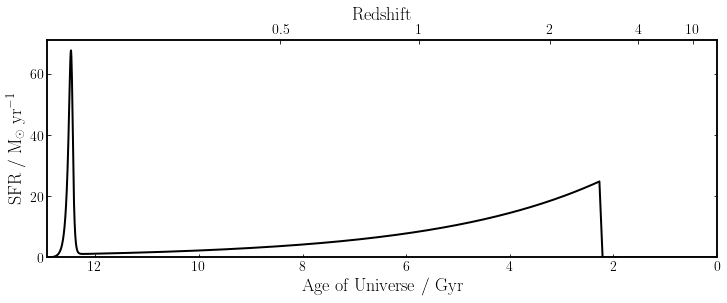

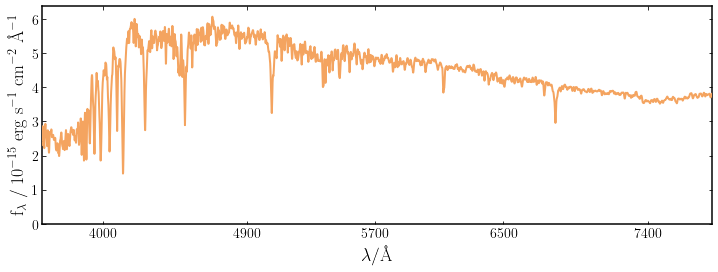

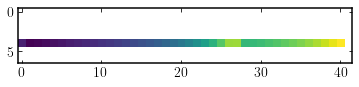

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'uniform'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


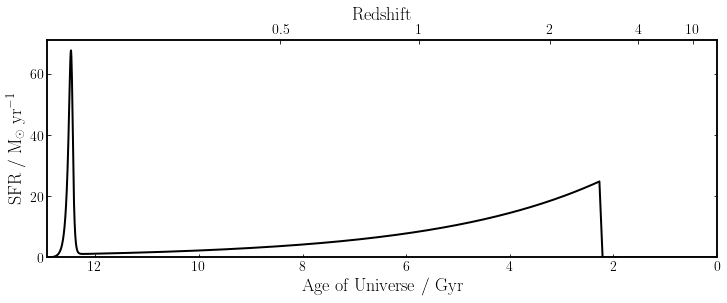

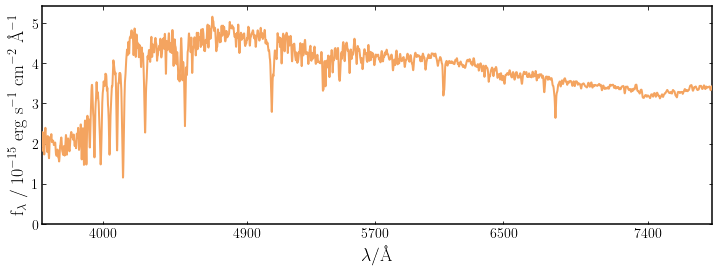

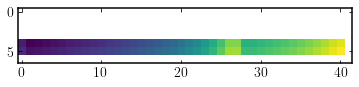

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'delta', 'metallicity': (0.01, 2.5), 'metallicity_prior': 'uniform'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


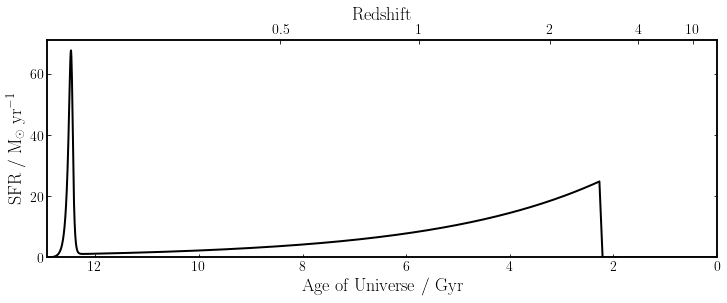

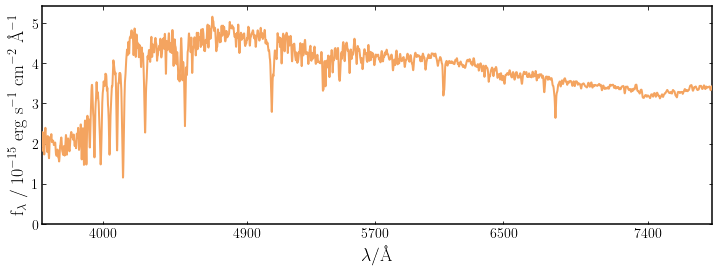

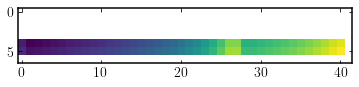

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'uniform', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'uniform'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


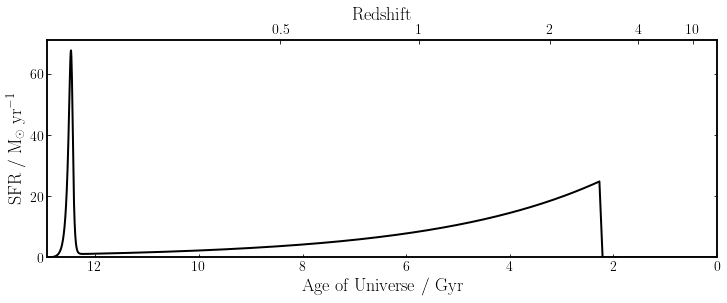

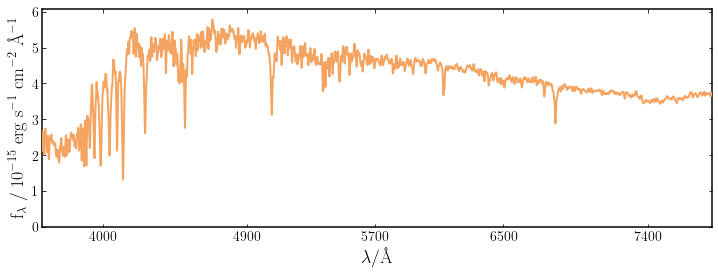

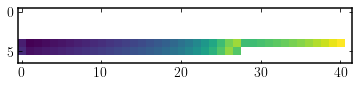

{'psb_wild2020': {'age': (4, 14.0), 'tau': (0.3, 10.0), 'massformed': (6, 13), 'burstage': (0, 2), 'alpha': (0.01, 1000), 'alpha_prior': 'log_10', 'beta': 500.0, 'fburst': (0, 1), 'metallicity_type': 'psb_two_step', 'metallicity_scatter': 'delta', 'metallicity_old': (0.01, 2.5), 'metallicity_old_prior': 'uniform', 'metallicity_burst': (0.01, 2.5), 'metallicity_burst_prior': 'uniform'}, 'redshift': (0.0392, 0.0408), 'veldisp': (0.1, 4000.0), 'veldisp_prior': 'log_10'}


In [10]:
# creating models, setting up fit instructions
models = []
instructions = []
for i,row in fit_table.iterrows():
    models.append(gen_model(row, vb=True))
    fit_instructions = get_fit_instructions(row)
    print(fit_instructions)
    instructions.append(fit_instructions)

In [11]:
# actually fitting
for i,row in fit_table.iterrows():
    print(f'run {i+1} of {len(fit_table.index)}')
    psb_model = models[i]
    fit_instructions = instructions[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, row['binby'], sky_masking=False, full=True,
                  model_galaxy_SNR=row['f_SNR'])
    
    ID = row['galID']
    runID = row['runID']
    print('runID =', runID)
    
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, fit_instructions, run=runID)
    fit.fit(verbose=False, n_live=row['f_nlive'])

run 1 of 4
runID = psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn

Results loaded from pipes/posterior/psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform1Zsun_veldisp100.h5

Fitting not performed as results have already been loaded from pipes/posterior/psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform1Zsun_veldisp100.h5. To start over delete this file or change run.

run 2 of 4
runID = psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn

Bagpipes: fitting object psb2_uniform2Zsun_veldisp100


Completed in 6639.8 seconds.

Parameter                          Posterior percentiles
                                16th       50th       84th
----------------------------------------------------------
psb_wild2020:age               9.927     11.127     12.202
psb_wild2020:alpha           222.768    233.659    246.960
psb_wild2020:burstage          0.454      0.464      0.473
psb_wild2020:fburst            0.0

In [12]:
def plot_spec(fit, ID, runID, save=True):

    # check if GP noise is on
    GPon = False
    if 'noise' in fit.fit_instructions.keys():
        if fit.fit_instructions['noise']["type"] == "GP_exp_squared":
            GPon = True
    
    # Make the figure
    matplotlib.rcParams.update({'font.size': 16})
    params = {'legend.fontsize': 16,
              'legend.handlelength': 1}
    matplotlib.rcParams.update(params)
    matplotlib.rcParams['text.usetex'] = True
    get_advanced_quantities(fit)

    if GPon == False:
        fig = plt.figure(figsize=(12, 5.))
        gs1 = matplotlib.gridspec.GridSpec(4, 1, hspace=0., wspace=0.)
        ax1 = plt.subplot(gs1[:3])
        ax3 = plt.subplot(gs1[3])
    else:
        fig = plt.figure(figsize=(12, 6.))
        gs1 = matplotlib.gridspec.GridSpec(5, 1, hspace=0., wspace=0.)
        ax1 = plt.subplot(gs1[:3])
        ax3 = plt.subplot(gs1[3])
        ax4 = plt.subplot(gs1[4])

    mask = fit.galaxy.spectrum[:, 2] < 1.
    masked_spec = np.where(fit.galaxy.spectrum[:,2]>1)[0]
    fit.galaxy.spectrum[mask, 2] = 0.

    y_scale = pipes.plotting.add_spectrum(fit.galaxy.spectrum, ax1, label='fitted obs spec')
    pipes.plotting.add_spectrum_posterior(fit, ax1, y_scale=y_scale)
    non_masked_obs_spec = np.delete(fit.galaxy.spectrum, masked_spec, axis=0)
    if ax1.get_ylim()[0] < 0.9*min(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(bottom=0.9*min(non_masked_obs_spec[:,1])*10**-y_scale)
    if ax1.get_ylim()[1] > 1.1*max(non_masked_obs_spec[:,1])*10**-y_scale:
        ax1.set_ylim(top=1.1*max(non_masked_obs_spec[:,1])*10**-y_scale)

    if 'noise' in fit.posterior.samples.keys():
        post_median = np.median(fit.posterior.samples["spectrum"]+fit.posterior.samples["noise"], axis=0)
    else:
        post_median = np.median(fit.posterior.samples["spectrum"], axis=0)

    #ax1.plot(fit.galaxy.spectrum[:,0],
    #         post_median*10**-y_scale,
    #         color="black", lw=1.0,zorder=11)
    
    #recover masks on spectrum and plot them as gray bands in residual plot
    mask_edges = [[masked_spec[0]],[]]
    for i,indi in enumerate(masked_spec[:-1]):
        if masked_spec[i+1] - indi > 1:
            mask_edges[1].append(indi)
            mask_edges[0].append(masked_spec[i+1])
    mask_edges[1].append(masked_spec[-1])
    mask_edges = np.array(mask_edges).T
    for [mask_min, mask_max] in mask_edges:
        ax3.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]], 
                         [-10,-10], [10,10], color='lightgray', zorder=2)

    residuals = (fit.galaxy.spectrum[:,1] - post_median)*10**-y_scale
    non_masked_res = np.delete(residuals, masked_spec)
    ax3.axhline(0, color="black", ls="--", lw=1)
    ax3.plot(np.delete(fit.galaxy.spectrum[:,0], masked_spec), non_masked_res, color="sandybrown", zorder=1)
    #ax3.plot(fit.galaxy.spectrum[:,0], residuals, color="sandybrown",zorder=1)
    ax3.set_ylabel('residual')
    ax3.set_ylim([1.1*min(non_masked_res), 1.1*max(non_masked_res)])
    ax3.set_xlim(ax1.get_xlim())
    
    if GPon:
        # Plot the noise factor
        if 'noise' in fit.posterior.samples.keys():
            noise_percentiles = np.percentile(fit.posterior.samples['noise'],(16,50,84),axis=0)*10**-y_scale
            ax4.plot(fit.galaxy.spectrum[:,0], noise_percentiles[1],color="sandybrown", zorder=1)
            ax4.fill_between(fit.galaxy.spectrum[:,0], noise_percentiles[0], noise_percentiles[2], 
                             color='navajowhite', zorder=-1)
        ax4.axhline(0, color="black", ls="--", lw=1)

        ax4_ylims = ax4.get_ylim()
        for [mask_min, mask_max] in mask_edges:
            ax4.fill_between([fit.galaxy.spectrum[:,0][mask_min], fit.galaxy.spectrum[:,0][mask_max]], 
                             [-10,-10], [10,10], color='lightgray', zorder=2)
        ax4.set_xlim(ax1.get_xlim())
        ax4.set_ylim(ax4_ylims)
        pipes.plotting.auto_x_ticks(ax4)
        ax4.set_xlabel("$\\lambda / \\mathrm{\\AA}$")
        ax4.set_ylabel('noise')
    
    if save:
        fig.savefig('pipes/plots/'+runID+'/'+ID+'_fit.pdf')
    plt.show()

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      1
m_zmet_burst                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_zmet_prior                                              uniform
f_dust                                                       None
f_GPnoise                                                   False
f_SNR                                                         100
f_nlive                                                       400
binby                                                           1
galID     

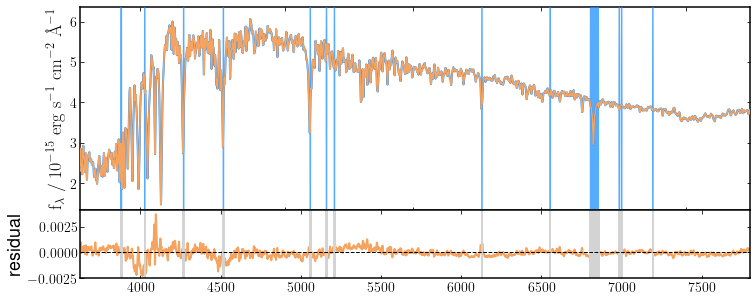

only recovered 0.999727715642377 of total mass formed.
10.932698686442443 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477389301648175
posterior f_burst and t_burst: [0.08841188 0.0919073  0.09485768] [12.45365596 12.46092662 12.4700481 ]


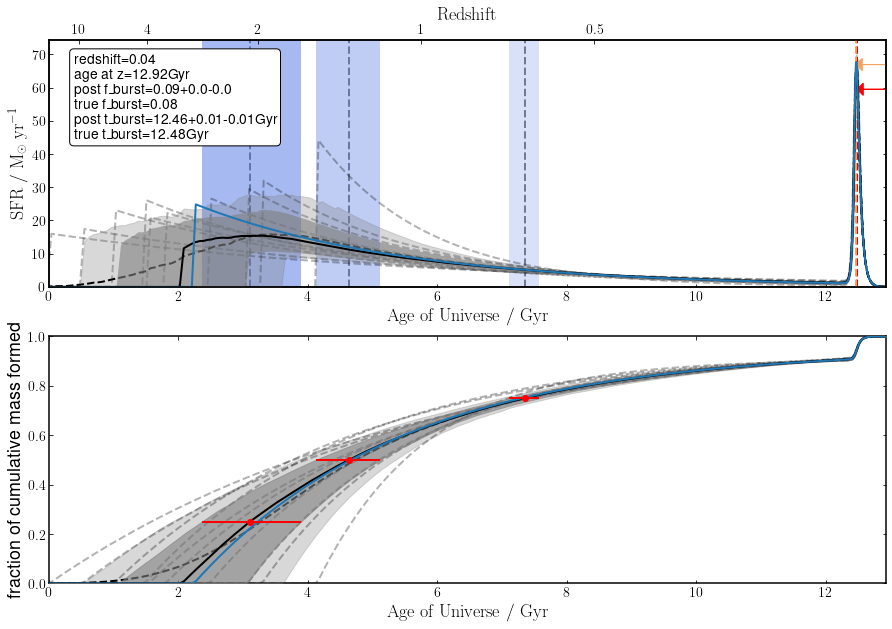

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      2
m_zmet_burst                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       delta
f_CEH_fixed                                                 False
f_zmet_prior                                              uniform
f_dust                                                       None
f_GPnoise                                                   False
f_SNR                                                         100
f_nlive                                                       400
binby                                                           1
galID     

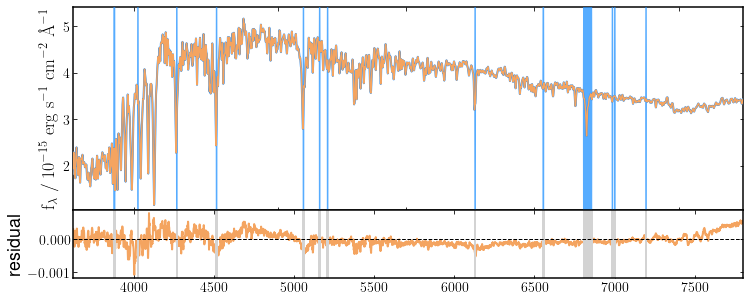

only recovered 1.0033050368602974 of total mass formed.
10.934249946665036 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477385410580585
posterior f_burst and t_burst: [0.08734836 0.09092193 0.09458299] [12.45204289 12.4601401  12.47001631]


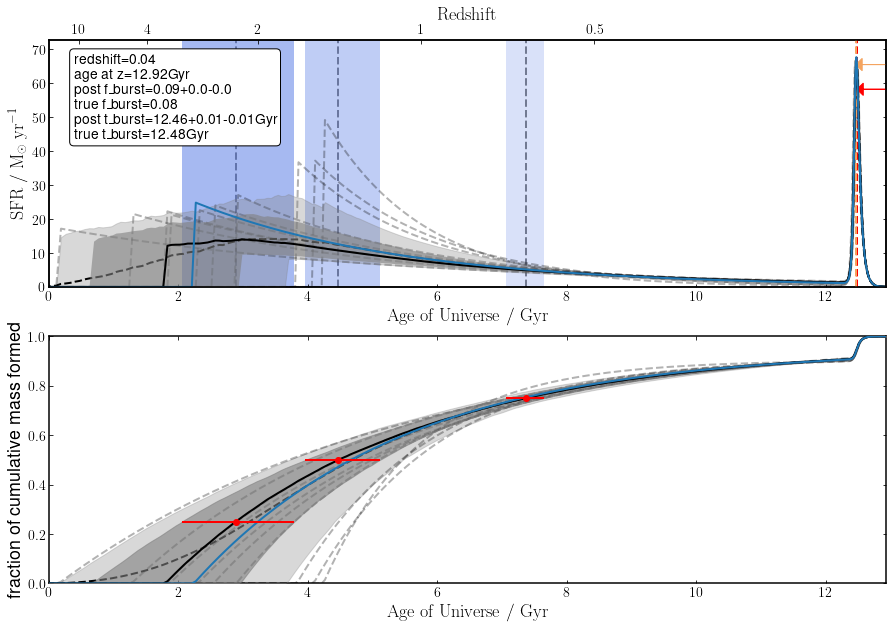

m_SFH                                                psb_wild2020
m_CEH                                                       delta
m_zmet_old                                                      2
m_zmet_burst                                                  NaN
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_zmet_prior                                              uniform
f_dust                                                       None
f_GPnoise                                                   False
f_SNR                                                         100
f_nlive                                                       400
binby                                                           1
galID     

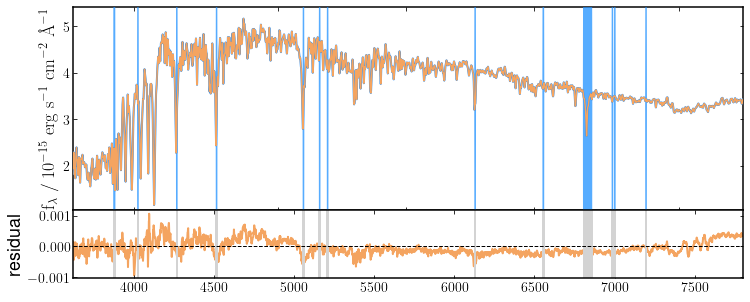

only recovered 1.0056574186318743 of total mass formed.
10.935267015836093 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477385693544413
posterior f_burst and t_burst: [0.08583894 0.09051522 0.09528245] [12.4514726  12.46100274 12.47201936]


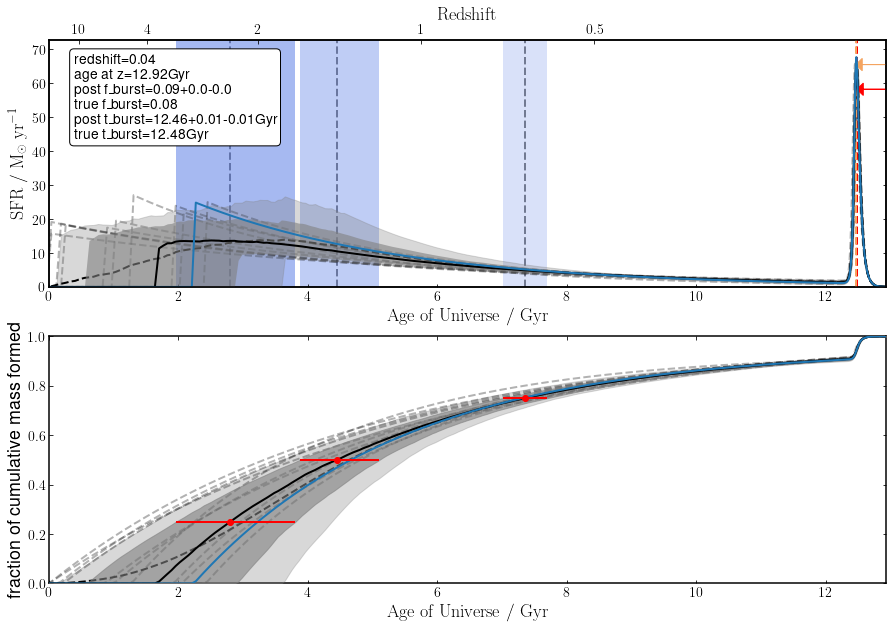

m_SFH                                                psb_wild2020
m_CEH                                                       2step
m_zmet_old                                                      1
m_zmet_burst                                                    2
m_dust                                                       None
m_veldisp                                                     100
f_SFH                                                psb_wild2020
f_CEH                                                       2step
f_CEH_fixed                                                 False
f_zmet_prior                                              uniform
f_dust                                                       None
f_GPnoise                                                   False
f_SNR                                                         100
f_nlive                                                       400
binby                                                           1
galID     

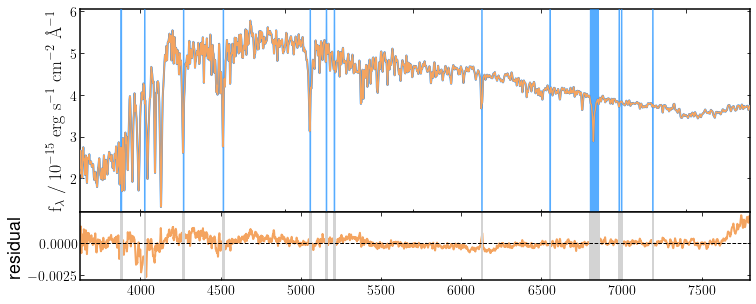

only recovered 0.9888301194484052 of total mass formed.
10.92793864055531 10.932816954138419
model f_burst and t_burst: 0.07789916376586054 12.477387347045108
posterior f_burst and t_burst: [0.08766754 0.09207769 0.09597868] [12.45113777 12.46234865 12.47335413]


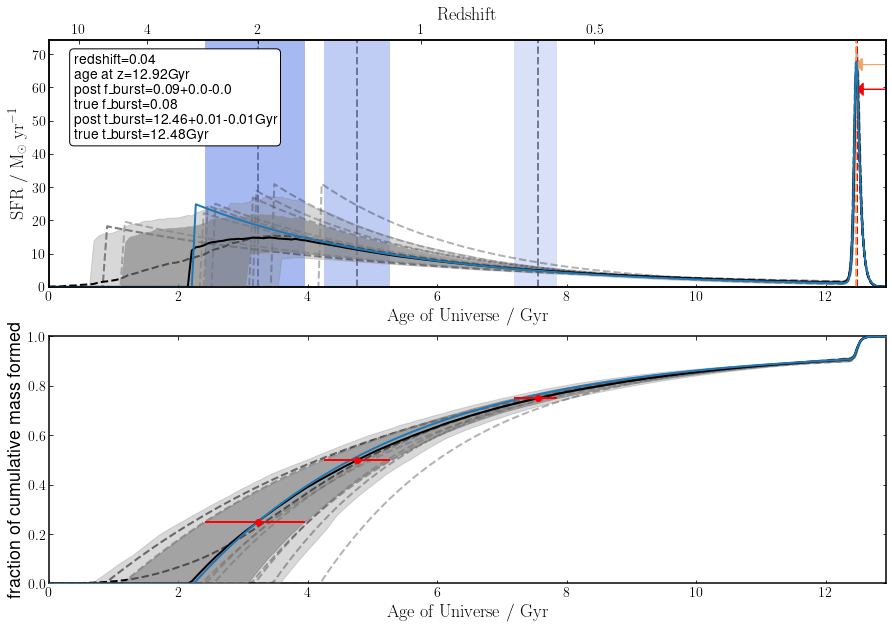

In [13]:
pipes.plotting.latex_names["metallicity_slope"] = "\\mathrm{Z_{slope}}"
pipes.plotting.latex_units["metallicity_slope"] = "Z_{\\odot}\\ Gyr^{-1}"
pipes.plotting.latex_names["metallicity_zero"] = "\\mathrm{Z_{0}}"
pipes.plotting.latex_units["metallicity_zero"] = "Z_{\\odot}"

import os
for i,row in fit_table.iterrows():
    if row['old_fit']:
        # all old_fits are only using psb_twin for model creation
        psb_twin_popt = [1.26348321e+01, 8.70221355e-01, 9.64793965e+03, 5.53510051e-01, 
                         1.83730405e+02, 6.79456054e+02, 8.64240632e-02, 1.10272314e+01]
        psb_model = gen_model(row, vb=False, old_fit_params=psb_twin_popt)
    else:
        psb_model = models[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, row['binby'], sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    print(row)
    print('runID =', runID)
    
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, {}, run=runID)
    
    if f'{ID}_fit.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        plot_spec(fit, ID, runID)
    if f'{ID}_corner.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        fig = fit.plot_corner(save=True, show=True)
    if f'{ID}_combined_sfh.pdf' not in os.listdir(f'pipes/plots/{runID}'):
        plot_sfh(fit, psb_model.sfh.ages*10**-9, psb_model.sfh.sfh,
                 ID, runID, samples=10, plot_mean=True, ninty_region=True)

In [15]:
# create master dataframe to hold all samples
samps_df_list = []
for i,row in fit_table.iterrows():
    psb_model = models[i]
    fit_obj = fitting('../../..', psb_model, 
                  0.04, row['binby'], sky_masking=False, full=True,
                  model_galaxy_SNR=15)
    
    ID = row['galID']
    runID = row['runID']
    galaxy = pipes.galaxy(ID, fit_obj.load_manga_spec, photometry_exists=False)
    pipes.config.Rspec = 4340
    fit = pipes.fit(galaxy, {}, run=runID)
    
    samps = fit.posterior.samples.copy()
    for key in ['sfh', 'spectrum', 'mass_weighted_age', 'tform', 'tquench', 
                'spectrum_full', 'uvj', 'formed_mass']:
        samps.pop(key, None)
    samps_df = pd.DataFrame(samps)
    for col in samps_df.columns:
        if ':' in col:
            samps_df.rename(columns={col: col.split(':')[1]}, inplace=True)
    samps_df.rename(columns={'alpha': 'alpha2', 'metallicity':'metallicity_old', 
                             'metallicity_zero':'metallicity_old'}, inplace=True)
    samps_df['galID'] = ID
    samps_df['runID'] = runID
    samps_df['fit_order'] = i
    samps_df_list.append(samps_df)
    
post_df = pd.concat(samps_df_list, ignore_index=True)
post_df = post_df[['massformed', 'fburst', 'age', 'tau', 'burstage', 'alpha2', 
                  'metallicity_old', 'metallicity_burst', 'redshift',
                  'veldisp', 'stellar_mass', 'sfr', 'ssfr', 'nsfr', 'galID', 'runID', 'fit_order']]
post_df
    


Results loaded from pipes/posterior/psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform1Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_delta_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform2Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_2step_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_uniform2Zsun_veldisp100.h5


Results loaded from pipes/posterior/psb2_2step_uniform_SNR100_nlive400_bin_by_1_4340_Rspec_veldispOn/psb2_2step1to2Zsun_veldisp100.h5



,massformed,fburst,age,tau,burstage,alpha2,metallicity_old,metallicity_burst,redshift,veldisp,stellar_mass,sfr,ssfr,nsfr,galID,runID,fit_order
0,10.948560,0.088818,11.785279,3.896106,0.469663,223.754180,0.985324,NaN,0.040000,99.625611,10.636627,0.081571,-11.725094,-1.925628,psb2_uniform1Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,0
1,10.933328,0.096461,9.743925,2.308906,0.478777,213.037794,1.005183,NaN,0.040001,100.485845,10.626038,0.099441,-11.628470,-1.824361,psb2_uniform1Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,0
2,10.956595,0.085820,12.618980,4.742386,0.465147,226.242462,1.000417,NaN,0.040001,99.770354,10.643166,0.081126,-11.734005,-1.936034,psb2_uniform1Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,0
3,10.941058,0.094580,10.784328,3.004276,0.480826,208.162736,1.027686,NaN,0.040001,100.889376,10.631630,0.110566,-11.588010,-1.786039,psb2_uniform1Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,0
4,10.930141,0.094970,10.359734,2.949108,0.472926,224.623047,0.994010,NaN,0.040003,99.744524,10.622557,0.076900,-11.736629,-1.932816,psb2_uniform1Zsun_veldisp100,psb2_delta_uniform_SNR100_nlive400_bin_by_1_43...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,10.920100,0.091969,10.771956,3.843774,0.459170,243.881540,1.043704,1.971065,0.040001,100.012852,10.613580,0.054376,-11.878173,-2.073294,psb2_2step1to2Zsun_veldisp100,psb2_2step_uniform_SNR100_nlive400_bin_by_1_43...,3
1996,10.939143,0.096700,10.767987,2.971150,0.485761,204.901163,1.058153,2.019176,0.039995,99.645923,10.629426,0.114180,-11.571835,-1.770151,psb2_2step1to2Zsun_veldisp100,psb2_2step_uniform_SNR100_nlive400_bin_by_1_43...,3
1997,10.949730,0.090236,11.559421,3.563257,0.471367,218.332899,0.986732,2.063522,0.039999,100.818284,10.637586,0.094186,-11.663600,-1.864343,psb2_2step1to2Zsun_veldisp100,psb2_2step_uniform_SNR100_nlive400_bin_by_1_43...,3
1998,10.926053,0.096024,9.860662,2.647338,0.472253,228.958980,1.033465,1.946219,0.040000,100.743874,10.619308,0.068784,-11.781820,-1.977165,psb2_2step1to2Zsun_veldisp100,psb2_2step_uniform_SNR100_nlive400_bin_by_1_43...,3


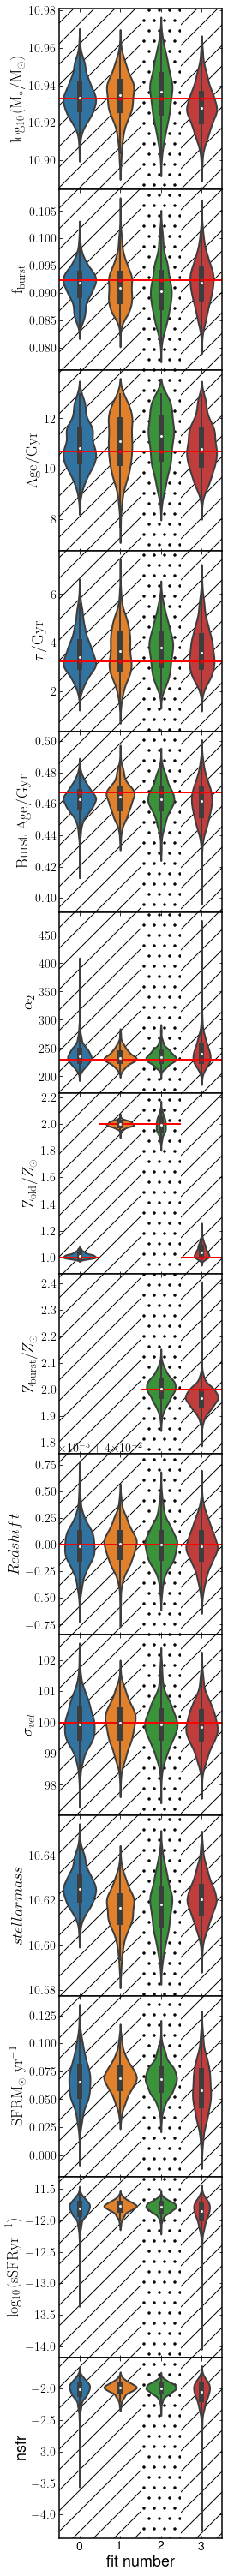

In [16]:
# age_list, age, tau, burstage, alpha, beta, fburst, Mstar
psb_wild2020_ind = {'age':popt_wild2020[0], 'tau':popt_wild2020[1], 'alpha1':np.nan, 
                    'burstage':popt_wild2020[2],
                    'alpha2':popt_wild2020[3], 'fburst':popt_wild2020[5], 'massformed':popt_wild2020[6]}
# age_list, age, alpha1, beta1, burstage, alpha2, beta2, fburst, Mstar
psb_twin_ind = {'age':popt_twin[0], 'tau':np.nan,
                'alpha1':popt_twin[1], 'burstage':popt_twin[3],
                'alpha2':popt_twin[4], 'fburst':popt_twin[6], 'massformed':popt_twin[7]}

ylabels = {
    "age": "\\mathrm{Age}/\\mathrm{Gyr}",
    "tau": "\\tau/\\mathrm{Gyr}",
    "alpha1": "\\alpha_1",
    "burstage": "\\mathrm{Burst\\ Age}/\\mathrm{Gyr}",
    "alpha2": "\\alpha_2",
    "fburst" : "\\mathrm{f_{burst}}",
    "massformed": "\\mathrm{log_{10}(M_*/M_{\\odot})}",
    "redshift": "Redshift",
    "veldisp": "\\sigma_{vel}",
    "stellar_mass": "stellar mass",
    "sfr": "\\mathrm{SFR}\\mathrm{M_\\odot\\ yr}^{-1}",
    "ssfr": "\\mathrm{log_{10}(sSFR\\mathrm{yr}^{-1})}",
    "metallicity_old": "\\mathrm{Z_{old}}/Z_{\\odot}",
    "metallicity_burst": "\\mathrm{Z_{burst}}/Z_{\\odot}",
    "metallicity_slope": "\\mathrm{Z_{slope}}/Z_{\\odot}\\ Gyr^{-1}"
          }

parameters = post_df.columns.drop(['galID', 'runID', 'fit_order'])
fig, ax = plt.subplots(len(parameters),1, figsize=[len(fit_table.index), 3*len(parameters)], sharex=True)
for i,col in enumerate(parameters):
    sns.violinplot(x='fit_order', y=col, data=post_df, ax=ax[i])
    # get truth values
    truth = [np.nan]*len(fit_table.index)
    
    # metallicity
    if col in ['metallicity_old', 'metallicity_burst', 'metallicity_slope']:
        truth = fit_table[f"m_zmet_{col.split('_')[-1]}"]
        for j,val in enumerate(truth):
            if val == 'auto':
                truth[j] = cosmo.age(0.04).value*abs(fit_table['m_zmet_slope'][j])
        for j in fit_table.index:
            if col == 'metallicity_old':
                if truth[j] == 'auto':
                    truth[j] = cosmo.age(0.04).value*abs(fit_table['m_zmet_slope'][j])
            elif col == 'metallicity_burst':
                if fit_table['m_CEH'][j] == 'delta' and fit_table['f_CEH'][j] in ['2step' ,'slope+2step']:
                    truth[j] = fit_table['m_zmet_old'][j]
            elif col == 'metallicity_slope':
                if fit_table['m_CEH'][j] in ['delta', '2step'] and fit_table['f_CEH'][j] == 'slope+2step':
                    truth[j] = 0
            
    elif col == 'veldisp':
        truth = fit_table['m_veldisp']
    elif col == 'redshift':
        truth = [0.04]*len(fit_table.index)
        
    # SFH properties
    elif col in ['age', 'burstage', 'alpha1', 'alpha2', 'fburst', 'massformed', 'tau']:
        truth = np.zeros(len(fit_table.index))
        for j in fit_table.index:
            if fit_table['m_SFH'][j] == 'psb_wild2020':
                truth[j] = psb_wild2020_ind[col]
            elif fit_table['m_SFH'][j] == 'psb_twin':
                truth[j] = psb_twin_ind[col]
            else:
                if col == 'massformed':
                    truth[j] = 11.027233041278691
                else:
                    truth[j] = np.nan
                
    ax[i].errorbar(np.arange(len(fit_table.index)), truth, xerr=0.5, ls='', marker='.', color='r')
    ax[i].set_xlabel('')
    if col in ylabels:
        ax[i].set_ylabel('$'+ylabels[col]+'$')
    else: ax[i].set_ylabel(col)
        
    ylims = ax[i].get_ylim()
    for j in fit_table.index:
        if fit_table['m_SFH'][j] == 'psb_wild2020':
            pass
        elif fit_table['m_SFH'][j] == 'psb_twin':
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, color='steelblue', alpha=0.4,
                              zorder=-20)
        else:
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, color='brown', alpha=0.2,
                              zorder=-20)
    
    for j in fit_table.index:
        if fit_table['m_SFH'][j] == fit_table['f_SFH'][j] and \
            fit_table['m_CEH'][j] == fit_table['f_CEH'][j] and \
            fit_table['m_dust'][j] == fit_table['f_dust'][j]:
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, fc='white', alpha=0.5,
                              hatch='/', zorder=-21)
        if fit_table['m_CEH'][j] != fit_table['f_CEH'][j]:
            ax[i].fill_between([j-0.5,j+0.5], [ylims[0]]*2, [ylims[1]]*2, fc='white', alpha=0.5,
                              hatch=".", zorder=-21)
            
    ax[i].set_ylim(ylims)

ax[0].set_xlim([-0.5,len(fit_table.index)-0.5])
ax[-1].set_xlabel('fit number')
plt.tight_layout()
plt.subplots_adjust(hspace=0)
#fig.savefig('metallicity model recovery tests2 violin.pdf')
plt.show()
#sns.violinplot(x='fit_order', y='massformed', data=post_df)
#plt.xlabel('fit')

In [23]:
fit.posterior.samples.pop(['uvj', 'tform'])

TypeError: unhashable type: 'list'

In [ ]:
# make huge violin plot comparing all fits, to their individual truths

